In [1]:
#import necessary packages and libraries
import timeit

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%%bash
make clean

rm -f *.out weak.txt caching.txt caching2.txt out.txt 
rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report report_*.txt out.txt


In [2]:
#define necessary functions 
def read_field_from_file(filename, num_halo=None):
    (rank, nbits, num_halo, nx, ny, nz) = np.fromfile(filename, dtype=np.int32, count=6)
    offset = (3 + rank) * 32 // nbits
    data = np.fromfile(
        filename,
        dtype=np.float32 if nbits == 32 else np.float64,
        count=nz * ny * nx + offset,
    )
    if rank == 3:
        return np.reshape(data[offset:], (nz, ny, nx))
    else:
        return np.reshape(data[offset:], (ny, nx))


def validate_results():
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    in_field = read_field_from_file("in_field.dat")
    im1 = axs[0].imshow(
        in_field[in_field.shape[0] // 2, :, :], origin="lower", vmin=-0.1, vmax=1.1
    )
    fig.colorbar(im1, ax=axs[0])
    axs[0].set_title("Initial condition")

    out_field = read_field_from_file("out_field.dat")
    im2 = axs[1].imshow(
        out_field[out_field.shape[0] // 2, :, :], origin="lower", vmin=-0.1, vmax=1.1
    )
    fig.colorbar(im2, ax=axs[1])
    axs[1].set_title("Final result")

    plt.show()

### Backend: OpenMP and MPI

#### K-parallel

In [3]:
%%bash

module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite
make VERSION=kparallel

make: 'stencil2d-kparallel.x' is up to date.


In [7]:
%%bash
srun -n 1 ./stencil2d-kparallel.x --nx 1024 --ny 1024 --nz 128 --num_iter 4096 > report_kparallel_iter4096.txt

CrayPat/X:  Version 21.09.0 Revision b02949528  08/17/21 03:14:02


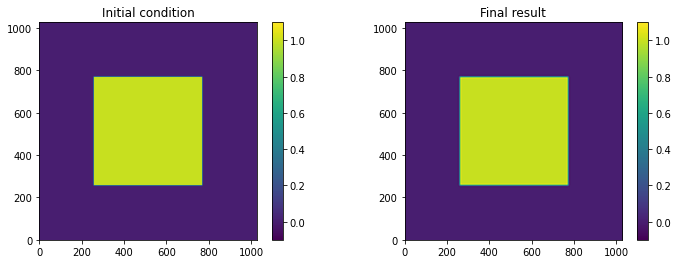

In [5]:
validate_results()

### Backend: Coarray 

In [8]:
%%bash

module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite
make VERSION=opencoarray

make: 'stencil2d-opencoarray.x' is up to date.


In [11]:
%%bash
srun -n 1 ./stencil2d-opencoarray.x --nx 1024 --ny 1024 --nz 128 --num_iter 4096 > report_opencoarray_4096.txt

CrayPat/X:  Version 21.09.0 Revision b02949528  08/17/21 03:14:02


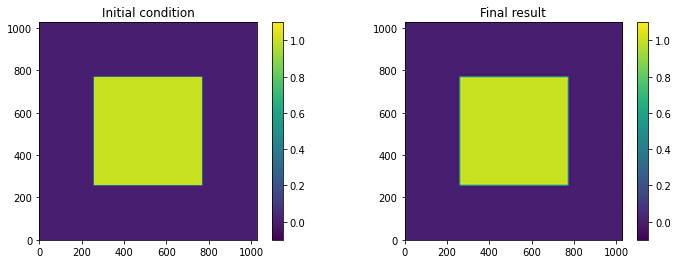

In [9]:
validate_results()